In [11]:
<h1 align="center">Logistic Regression</h1> 

SyntaxError: invalid syntax (<ipython-input-11-69b64fa45fff>, line 1)

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов для каждого объекта) является логистическая регрессия, лог регрессия настраивается с помощью метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{1}{2} ||w||^2-> \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Чем лог-регрессия отличается от svm?

<Ответ>

**Вопрос 2**: Почему считается что регуляризатор мешает переобучаться? Что такое переобучение?

В ходе обучения какие-то веса могут получить слишком большие/маленькие значения и они в очень большей/меньшей степени будут влиять на результат классификатора, что плохо, потому что это значит, что произошло переобучение на трениноговой выборке, а на тестовой эти веса могут испортить предсказания классификатора. Регуляризатор позволяет уменьшать слишком большие веса и увеличивать слишком маленькие.

**Вопрос 3**: Почему лог-регрессия это классификатор?

По знаку $Xw$ можно отнести объект тому или иному классу

### Лог-регрессия своими руками

In [47]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Для тестирования правильности вычисления сгенерируем аргументы, небольшого размера
w, X, y = np.random.random(4), np.random.random((5, 4)), 2*(np.random.randint(0, 2, 5)-0.5)

In [49]:
print w

[ 0.74092437  0.31768074  0.63980512  0.40512482]


### Шаг 1

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов -- циклы спрятанны в матричные умножения).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(·))`.

In [50]:
def logistic(w, X, y):
    """
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        
        funcw: np.float 
    """
    y_pred=np.dot(X,w)
    funcw = np.sum(np.logaddexp(-y*y_pred,0)) # Вычислите функцию L
    norm=np.linalg.norm(w,ord=2)
    funcw=funcw+0.5*(norm*norm)
    #funcw = np.sum(np.log(1+np.exp(-y*y_pred)))
    return funcw

In [51]:
logistic(w, X, y)

3.683610563591929

In [52]:
isinstance(logistic(w, X, y), float) # Результат число, этож функция потерь.

True

### Шаг 2

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций, эффективно запрограммируйте вычисленный градиент.

In [53]:
def logistic_grad(w, X, y):
    """
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    """
    gradw=np.zeros_like(w) # Вычислите градиент функции dL/dw
    err=sp.expit(-y*np.dot(X,w))
    gradw=-y*err
    gradw=np.dot(gradw,X)+w
    return gradw

In [54]:
logistic_grad(w, X, y)

array([ 0.87770538,  0.25570643,  0.4167497 ,  1.02622334])

In [55]:
assert(logistic_grad(w, X, y).shape == w.shape) # Результат вектор, этож градиент.

### Шаг 3

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью функции scipy.optimize.check_grad, ошибка должна быть ~ 1e-8 или меньше.

In [56]:
from scipy.optimize import check_grad

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)

print('error = %s' % check_grad(func, grad, w))

error = 5.3284665294e-08


### Шаг 4

А теперь найдем $w$ используя метод оптимизации optimize.fmin_l_bfgs_b применим к реальным данным.

In [61]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score as acc
from scipy.optimize import fmin_l_bfgs_b
X, y = make_classification(n_features=20, n_informative=3, n_classes=2, )
y = 2*(y - 0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=23)

In [62]:
w = np.zeros_like(X[0]) # Начальное значение параметров w
func = lambda w: logistic(w, X_train, y_train)
grad = lambda w: logistic_grad(w, X_train, y_train)

w = fmin_l_bfgs_b(func,w,grad)

In [63]:
print('train acc = ', acc(np.sign(X_train.dot(w[0])), y_train), 'test acc = %s' % acc(np.sign(X_test.dot(w[0])), y_test))

('train acc = ', 0.92000000000000004, 'test acc = 0.8')


### Шаг 5, Давайте визуализируем наш метод, а то хочется глазами посмотреть

In [64]:
from scipy import optimize

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, X, y, n_iter=10, lr=1e-3):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w = np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx = func(w), grad(w)
        w = optimize.fmin_l_bfgs_b(func, w, approx_grad=grad)[0]
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [65]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

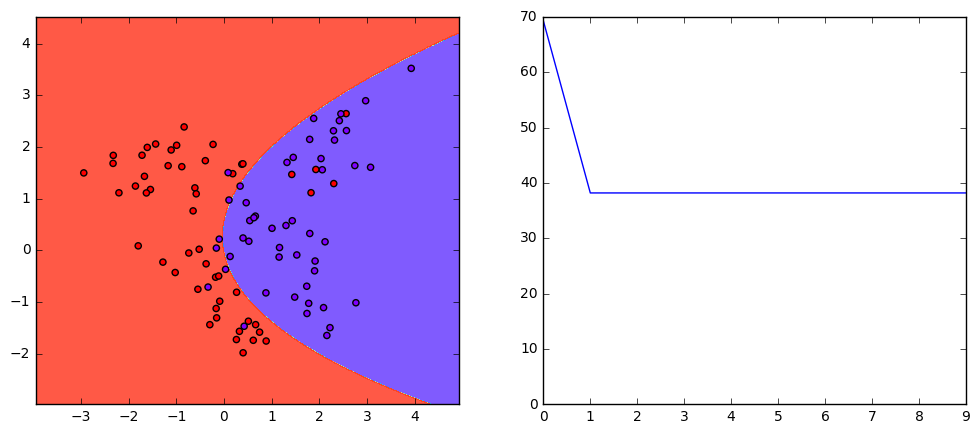

In [66]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, X, y) 

### Шаг 6 Сдать ДЗ

In [67]:
X = np.array([
    [ 0.11276959,  0.44971499,  0.9923867 ,  0.89212961],
    [ 0.82695301,  0.30505746,  0.40539034,  0.68335903],
    [ 0.98938714,  0.34498564,  0.36259562,  0.46714136],
    [ 0.46335495,  0.62208345,  0.95386954,  0.41550278],
    [ 0.91471692,  0.69649708,  0.82290076,  0.86441013]])

w = np.array([ 0.45920206,  0.24257981,  0.96715112,  0.21759684])
y = np.array([-1., -1., -1., -1.,  1.])

In [68]:
# Заполните форму https://goo.gl/forms/nRSQuIk8olbmVRIi1 

print('значение функции потерь %.2f'   % logistic(w, X, y))
print('значение суммы градиентов %.2f' % logistic_grad(w, X, y).sum())

значение функции потерь 6.58
значение суммы градиентов 8.41
